In [1]:
cd ../src

/Users/dani/Google Drive/Uni/Master/P4 2021/DD2424 - Deep Learning for Data Science/Project/ScarceClassifier/src


In [17]:
from d07_visualization.viz_training import plot_acc, plot_training_loss, plot_losses
from d04_mixmatch.wideresnet import WideResNet
import torch

In [18]:
model_name = 'sgd_20k.pt'
saved_model = torch.load(f'../models/{model_name}', map_location=torch.device('cpu')) 

model = WideResNet(depth=28, k=2, n_out=10)
model.load_state_dict(saved_model['model_state_dict'])

# optim = ...
# optim.load_state_dict(saved_model['optimizer_state_dict'])

loss_train = saved_model['loss_train']
loss_val = saved_model['loss_val']
acc_train = saved_model['acc_train']
acc_val = saved_model['acc_val']

loss_batch = saved_model['loss_batch']
lx = saved_model['lx']
lu = saved_model['lu']
lu_weighted = saved_model['lu_weighted']


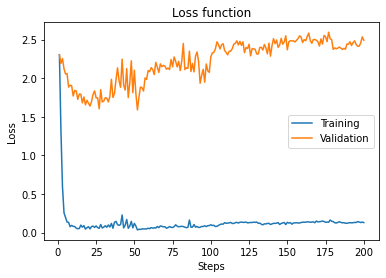

In [20]:
plot_training_loss(loss_train, loss_val)


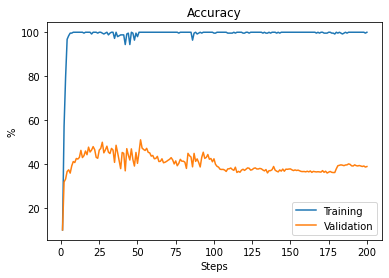

In [21]:
plot_acc(acc_train, acc_val)

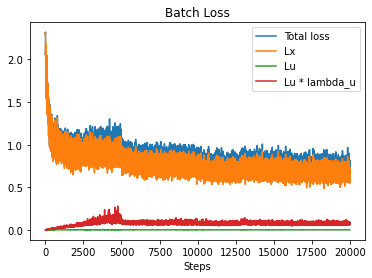

In [22]:
plot_losses(loss_batch, lx, lu, lu_weighted)